In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


In [2]:
# Paths to your directories and files
image_dir = os.path.expanduser('C:/Users/USER/Downloads/New plant/Images')

# Prepare the ImageDataGenerator for training and validation
image_gen = ImageDataGenerator(
    rescale=1./255,           # Rescale pixel values
    validation_split=0.2,     # Split for validation
    shear_range=0.2,          # Shearing transformation
    zoom_range=0.2,           # Zoom augmentation
    horizontal_flip=True      # Horizontal flip augmentation
)

# Load training and validation datasets
train_data = image_gen.flow_from_directory(
    image_dir,
    target_size=(150, 150),   # Resize images
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = image_gen.flow_from_directory(
    image_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 21416 images belonging to 45 classes.
Found 5330 images belonging to 45 classes.


Class Distribution:
Apple_Blackrot: 79 images
Apple_CedarRust: 36 images
Apple_healthy: 1232 images
Apple_scab: 41 images
Bellpepper_BacterialSpot: 39 images
Bellpepper_Healthy: 40 images
Cashew_RedRust: 1346 images
Cashew_anthracnose: 1384 images
Cashew_gumosis: 314 images
Cashew_healthy: 1095 images
Cashew_leafminer: 1103 images
Cassava green mite: 812 images
Cassava_bacterialblight: 2092 images
Cassava_brownspot: 1185 images
Cassava_healthy: 955 images
Cassava_mosaic: 964 images
Cherry_PowderyMildew: 35 images
Cherry_healthy: 37 images
Grape_Esca(Black Measles): 39 images
Grape_LeafBlight: 35 images
Grape_healthy: 35 images
Maize_CercosporaLeafSpot: 997 images
Maize_CommonRust: 39 images
Maize_NorthernLeafBlight: 796 images
Maize_fallarmyworm: 228 images
Maize_healthy: 200 images
Maize_streakvirus: 772 images
Peach_BacterialSpot: 37 images
Peach_healthy: 36 images
Potato_EarlyBlight: 40 images
Potato_LateBlight: 40 images
Potato_healthy: 37 images
Rice_BacterialLeafBlight: 32 images

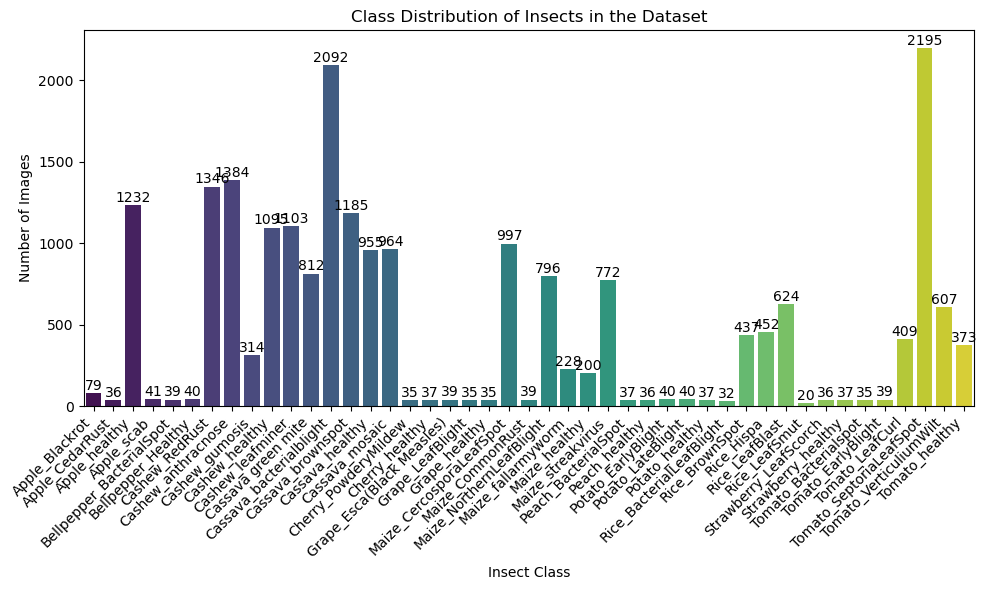

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get class indices and corresponding labels
class_indices = train_data.class_indices
labels = list(class_indices.keys())

# Count the number of images per class
class_counts = train_data.classes  # Array of class indices for each image
unique, counts = np.unique(class_counts, return_counts=True)

# Convert the class distribution to a dictionary
class_distribution = dict(zip(labels, counts))

# Print the class distribution
print("Class Distribution:")
for label, count in class_distribution.items():
    print(f"{label}: {count} images")

# Plot the class distribution
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette='viridis')

# Annotate the bars with the counts
for i, count in enumerate(list(class_distribution.values())):
    ax.text(i, count + 1, str(count), ha='center', va='bottom')

plt.title('Class Distribution of Insects in the Dataset')
plt.xlabel('Insect Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the ResNet152V2 model without the top layer (include_top=False) for custom classification
base_model = ResNet152V2(include_top=False, input_shape=(150, 150, 3), weights='imagenet')

# Freeze the layers in the base model to prevent training them initially
base_model.trainable = False

# Add custom layers on top of the ResNet152V2 base model
x = base_model.output
x = Flatten()(x)  # Flatten the output from ResNet
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
output = Dense(train_data.num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with the Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Early stopping callback to stop after 3 epochs if validation loss does not improve
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model on the training data with validation, max of 50 epochs
history = model.fit(
    train_data,
    epochs= 3,  # Maximum number of epochs, but early stopping may halt it earlier
    validation_data=val_data,
    callbacks=[early_stopping],
    verbose=1
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 38, 38,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 38, 38,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 40, 40,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 38, 38,    │          0 │ conv2_block1_0_c

 Total params: 84,569,645 (322.61 MB)

 Trainable params: 26,237,997 (100.09 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

Epoch 1/3
670/670 ━━━━━━━━━━━━━━━━━━━━ 4220s 6s/step - accuracy: 0.4726 - loss: 2.1384 - val_accuracy: 0.5741 - val_loss: 1.3094
Epoch 2/3
670/670 ━━━━━━━━━━━━━━━━━━━━ 4162s 6s/step - accuracy: 0.6658 - loss: 1.0256 - val_accuracy: 0.6189 - val_loss: 1.1469
Epoch 3/3
670/670 ━━━━━━━━━━━━━━━━━━━━ 4114s 6s/step - accuracy: 0.7055 - loss: 0.8615 - val_accuracy: 0.6296 - val_loss: 1.0946


In [6]:
model.save('pest_identification_model.keras')

In [7]:
model = tf.keras.models.load_model('pest_identification_model.keras')
print("Model saved and loaded successfully.")

Model saved and loaded successfully.


In [11]:
# Example of using the model to make a prediction
import numpy as np
from tensorflow.keras.preprocessing import image

# Assuming 'img' is the uploaded image
img = image.load_img("C:/Users/USER/Downloads/New plant/Images/Cashew_gumosis/gumosis2_.jpg", target_size=(150, 150))  # Adjust the size if needed
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make a prediction
prediction = model.predict(img_array)
print(prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the CSV file with insect details

pest_df = pd.read_csv('Plant disease.csv')

# Function to predict insect and fetch details
def predict_pest(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the insect type
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    class_labels = list(train_data.class_indices.keys())
    pest_name = class_labels[predicted_class]

    # Fetch details from the CSV
    pest_info = pest_df[pest_df['crop_disease'] == pest_name]


    if not pest_info.empty:
        # Extract the insect details
        Disadvantages = pest_info['Disadvantages'].values[0]
        First_Aid_Short_Term = pest_info['First_Aid_Short_Term'].values[0]
        First_Aid_Long_Term = pest_info['First_Aid_Long_Term'].values[0]
        Pesticides_Treatments = pest_info['Pesticides/ Treatments'].values[0]
        Maintenance_Recommendations = pest_info['First_Aid_Long_Term'].values[0]

        print(f"Disadvantages: {Disadvantages}")
        print(f"First_Aid_Short_Term: {First_Aid_Short_Term}")
        print(f"First_Aid_Long_Term: {First_Aid_Long_Term}")
        print(f"Pesticides/ Treatments: {Pesticides_Treatments}")
        print(f"Maintenance_Recommendations: {Maintenance_Recommendations}")
    else:
        print("pest details not found in the dataset.")



Dataset Preview:
               crop_disease  \
0                Apple_scab   
1            Apple_Blackrot   
2           Apple_CedarRust   
3             Apple_healthy   
4  Bellpepper_BacterialSpot   

                                       Disadvantages  \
0  Reduces fruit quality, causes leaf and fruit s...   
1           Causes fruit rot and cankers on branches   
2          Causes leaf spots, reduces photosynthesis   
3                                         No disease   
4  Causes lesions on leaves and fruit, reducing y...   

                               First_Aid_Short_Term  \
0      Remove infected leaves, prune infected areas   
1    Remove and destroy infected fruit and branches   
2     Remove nearby juniper plants (alternate host)   
3                                               NaN   
4  Remove infected plants, increase air circulation   

                                First_Aid_Long_Term  \
0  Apply resistant varieties, prune trees regularly   
1   Apply resistan

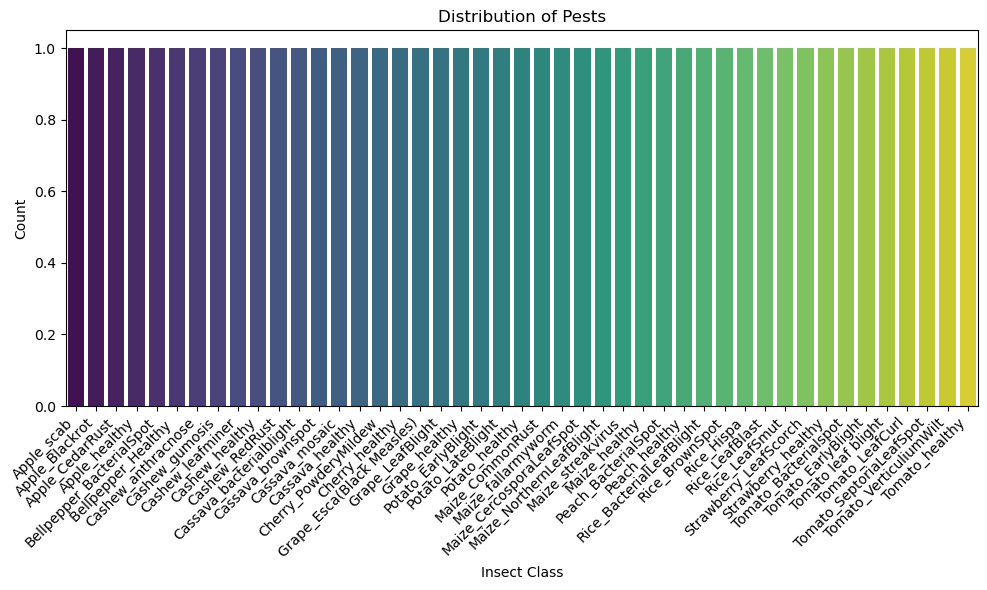


Unique values in 'crop_disease':
['Apple_scab' 'Apple_Blackrot' 'Apple_CedarRust' 'Apple_healthy'
 'Bellpepper_BacterialSpot' 'Bellpepper_Healthy ' 'Cashew_anthracnose'
 'Cashew_gumosis' 'Cashew_leafminer' 'Cashew_healthy' 'Cashew_RedRust'
 'Cassava_bacterialblight' 'Cassava_brownspot' 'Cassava_mosaic'
 'Cassava_healthy' 'Cherry_PowderyMildew' 'Cherry_healthy'
 'Grape_Esca(Black Measles)' 'Grape_LeafBlight' 'Grape_healthy'
 'Potato_EarlyBlight' 'Potato_LateBlight' 'Potato_healthy'
 'Maize_CommonRust' 'Maize_fallarmyworm' 'Maize_CercosporaLeafSpot'
 'Maize_NorthernLeafBlight' 'Maize_streakvirus' 'Maize_healthy'
 'Peach_BacterialSpot' 'Peach_healthy' 'Rice_BacterialLeafBlight'
 'Rice_BrownSpot' 'Rice_Hispa' 'Rice_LeafBlast' 'Rice_LeafSmut'
 'Strawberry_LeafScorch' 'Strawberry_healthy' 'Tomato_Bacterialspot'
 'Tomato_EarlyBlight' 'Tomato leaf blight' 'Tomato_LeafCurl'
 'Tomato_SeptoriaLeafSpot' 'Tomato_VerticuliumWilt' 'Tomato_healthy']

Unique values in 'Disadvantages':
['Reduces fruit 

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display the first few rows of the dataset
print("Dataset Preview:")
print(pest_df.head())

# Display general information about the dataset
print("\nDataset Information:")
print(pest_df.info())

# Display descriptive statistics
print("\nDescriptive Statistics:")
print(pest_df.describe(include='all'))

# Check for missing values
print("\nMissing Values:")
print(pest_df.isnull().sum())

# Visualize the distribution of insects in the dataset
plt.figure(figsize=(10, 6))
sns.countplot(data=pest_df, x='crop_disease', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Pests')
plt.xlabel('Insect Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Display unique values for categorical columns
for column in pest_df.select_dtypes(include=['object']).columns:
    print(f"\nUnique values in '{column}':")
    print(pest_df[column].unique())


In [ ]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)


2.18.0
3.6.0
